In [1]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [2]:
raw_train = np.load('../Grid_LSTM/POD/train_z500_coeffs.npy').T[:,:20]
raw_test = np.load('../Grid_LSTM/POD/train_z500_coeffs.npy').T[:,:20]

In [3]:
raw_train.shape

(12564, 20)

In [4]:
scaler = MinMaxScaler()
train_coeffs = scaler.fit_transform(raw_train)
test_coeffs = scaler.transform(raw_test)

In [5]:
input_window = 14
output_window = 7

train_inputs = []
train_outputs = []

i = 0
while i < train_coeffs.shape[0] - input_window - output_window:
    train_inputs.append(train_coeffs[i:i+input_window])
    train_outputs.append(train_coeffs[i+input_window:i+input_window+output_window])
    i = i + 1
    
train_inputs = np.asarray(train_inputs)
train_outputs = np.asarray(train_outputs)

In [6]:
embed_dim = train_inputs[0].shape[-1]

In [7]:
# input_shape = train_inputs.shape[-1]
# output_shape = train_outputs.shape[-1]

# class TokenAndPositionEmbedding(layers.Layer):
#     def __init__(self, embed_dim):
#         super(TokenAndPositionEmbedding, self).__init__()
#         self.token_emb = layers.Dense(input_dim=input_shape, units=embed_dim) # Adapted for real valued input
#         self.pos_emb = layers.Embedding(input_dim=input_shape, output_dim=embed_dim)

#     def call(self, x):
#         maxlen = tf.shape(x)[-1]
#         positions = tf.range(start=0, limit=maxlen, delta=1)
#         positions = self.pos_emb(positions)
#         x = self.token_emb(x)
        
#         print(tf.shape(x))
#         print(tf.shape(positions))
        
#         return x + positions

In [8]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="elu"),layers.Dense(ff_dim, activation="elu"),
             layers.Dense(ff_dim, activation="elu"),layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        
        self.pos_emb = layers.Embedding(input_dim=input_window, output_dim=embed_dim)
        positions = tf.range(start=0, limit=input_window, delta=1)
        self.positions = self.pos_emb(positions)
        

    def call(self, inputs, training=False):
        inputs = inputs + self.positions
            
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [10]:
num_heads = 5  # Number of attention heads
ff_dim = 50  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0

inputs = layers.Input(shape=(input_window,embed_dim))
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate = dropout_rate)
x = transformer_block(inputs)
x = tf.reshape(x,[-1,input_window*embed_dim])

x = layers.Dense(100, activation="elu")(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(100, activation="elu")(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(100, activation="elu")(x)
x = layers.Dropout(dropout_rate)(x)

outputs = layers.Dense(output_window*embed_dim, activation="linear")(x)
outputs = tf.reshape(outputs,[-1,output_window,embed_dim])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss',patience=20)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14, 20)]          0         
_________________________________________________________________
transformer_block (Transform (None, 14, 20)            15850     
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 280)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               28100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0     

In [13]:
history = model.fit(train_inputs,train_outputs,epochs=200,batch_size=78,callbacks=[reduce_lr,early_stop],validation_split=0.2)

Epoch 1/200
129/129 [==============================] - 3s 12ms/step - loss: 0.0881 - val_loss: 0.0150
Epoch 2/200
129/129 [==============================] - 1s 8ms/step - loss: 0.0147 - val_loss: 0.0139
Epoch 3/200
129/129 [==============================] - 1s 8ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 4/200
129/129 [==============================] - 1s 8ms/step - loss: 0.0134 - val_loss: 0.0136
Epoch 5/200
129/129 [==============================] - 1s 9ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 6/200
129/129 [==============================] - 1s 9ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 7/200
129/129 [==============================] - 1s 9ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 8/200
129/129 [==============================] - 1s 9ms/step - loss: 0.0133 - val_loss: 0.0135
Epoch 9/200
129/129 [==============================] - 1s 9ms/step - loss: 0.0133 - val_loss: 0.0131
Epoch 10/200
129/129 [==============================] - 1s 9ms/step - loss: 0.0130 - val_l

129/129 [==============================] - 2s 15ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 79/200
129/129 [==============================] - 2s 14ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 80/200
129/129 [==============================] - 2s 14ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 81/200
129/129 [==============================] - 2s 12ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 82/200
129/129 [==============================] - 2s 13ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 83/200
129/129 [==============================] - 2s 12ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 84/200
129/129 [==============================] - 2s 12ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 85/200
129/129 [==============================] - 2s 12ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 86/200
129/129 [==============================] - 2s 13ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 87/200
129/129 [==============================] - 1s 11ms/step - loss: 0.0112 - 

129/129 [==============================] - 1s 10ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 158/200
129/129 [==============================] - 1s 11ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 159/200
129/129 [==============================] - 1s 11ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 160/200
129/129 [==============================] - 1s 10ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 161/200
129/129 [==============================] - 1s 10ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 162/200
129/129 [==============================] - 2s 12ms/step - loss: 0.0110 - val_loss: 0.0116
Epoch 163/200
129/129 [==============================] - 1s 12ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 164/200
129/129 [==============================] - 1s 11ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 165/200
129/129 [==============================] - 1s 11ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 166/200
129/129 [==============================] - 1s 11ms/step - loss: 

In [14]:
model.save('/tmp/model')

INFO:tensorflow:Assets written to: /tmp/model/assets


INFO:tensorflow:Assets written to: /tmp/model/assets


In [15]:
import matplotlib.pyplot as plt

In [16]:
pred_outputs = model.predict(train_inputs)

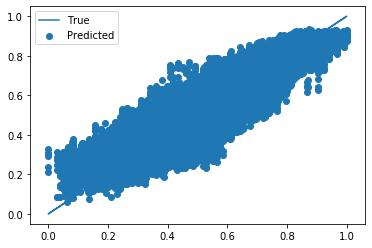

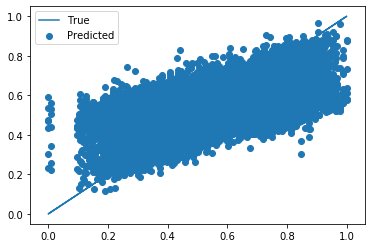

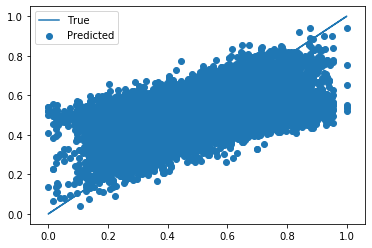

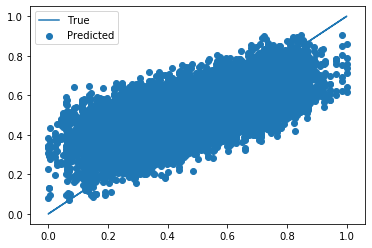

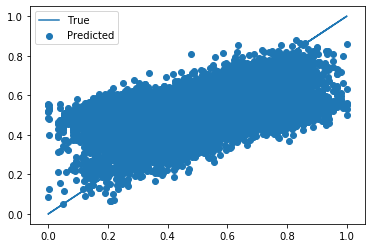

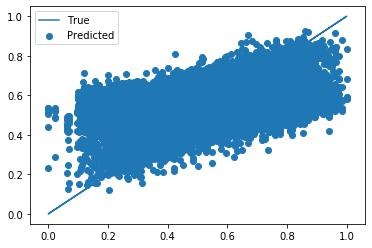

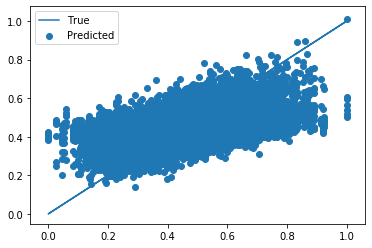

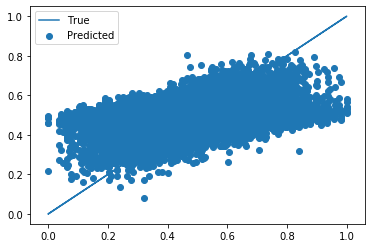

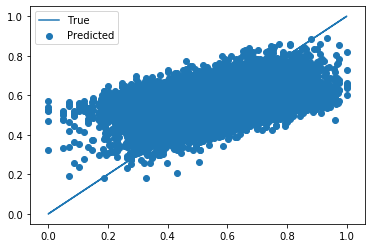

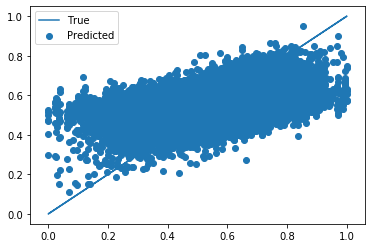

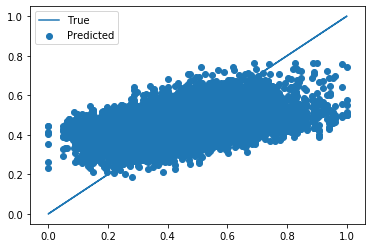

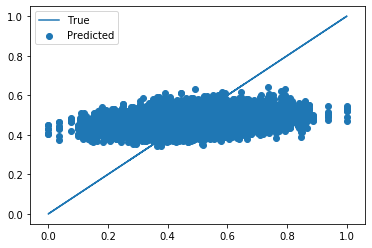

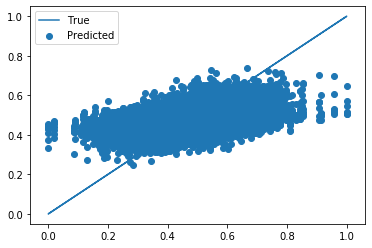

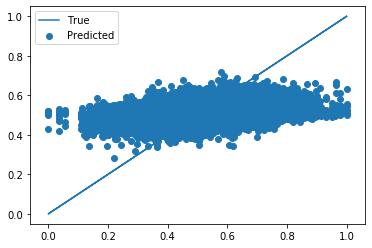

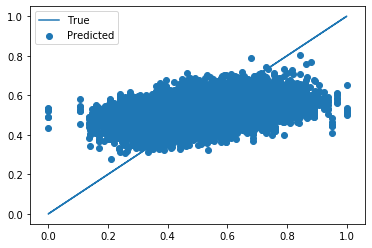

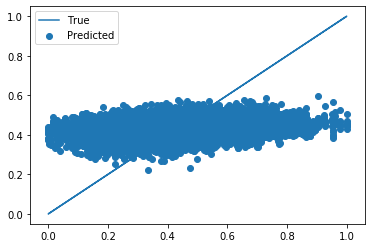

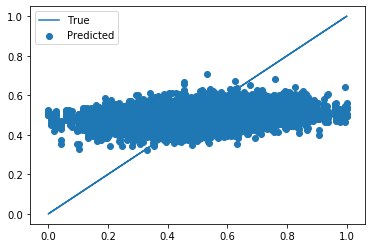

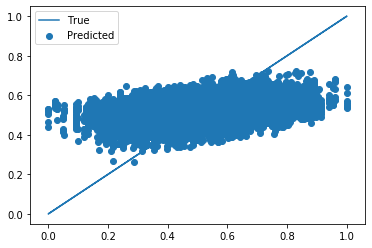

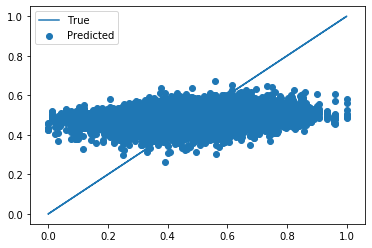

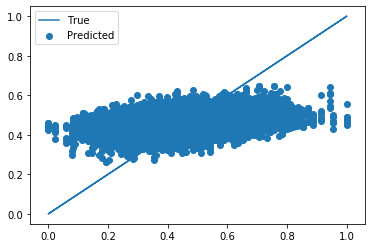

In [27]:
for mode_num in range(20):

    plt.figure()
    plt.plot(train_outputs[:,:,mode_num].flatten(),train_outputs[:,:,mode_num].flatten(),label='True')
    plt.scatter(train_outputs[:,:,mode_num].flatten(),pred_outputs[:,:,mode_num].flatten(),label='Predicted')
    plt.legend()
    plt.show()

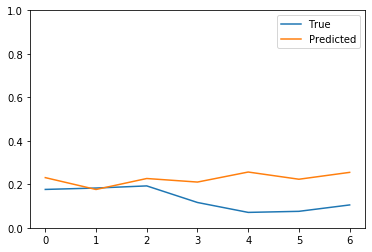

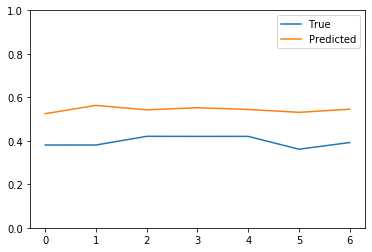

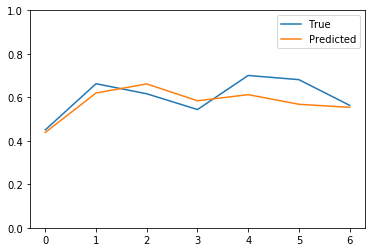

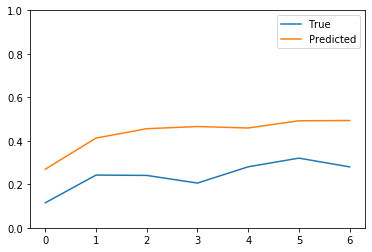

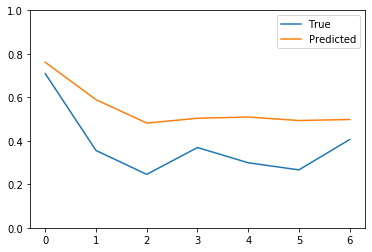

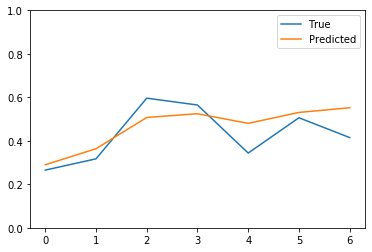

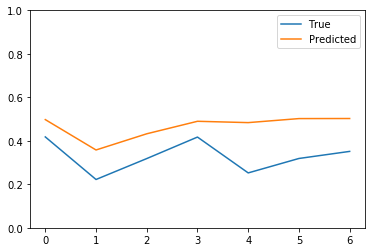

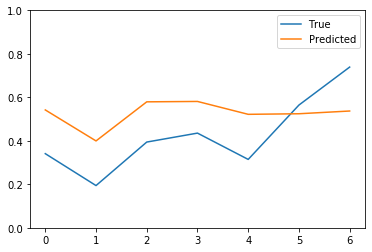

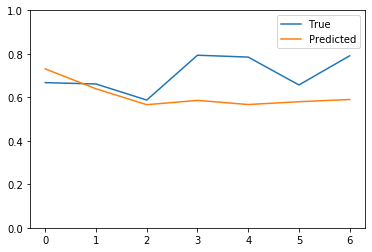

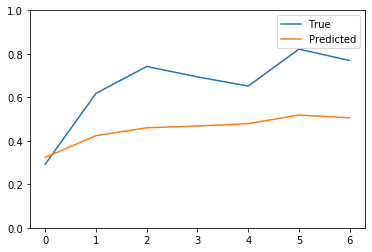

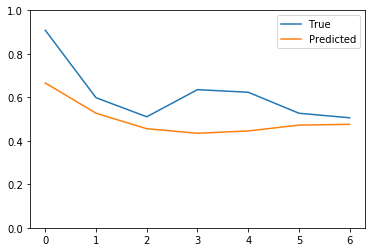

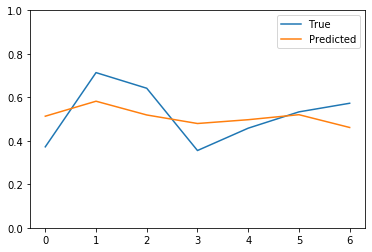

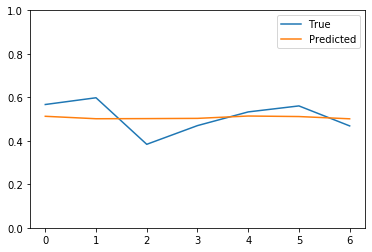

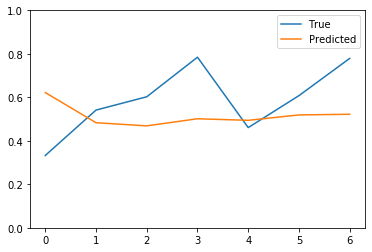

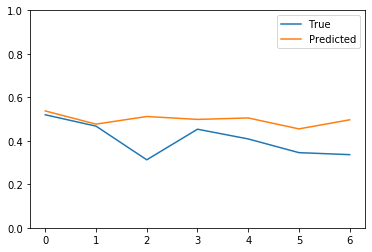

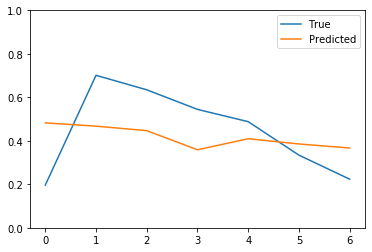

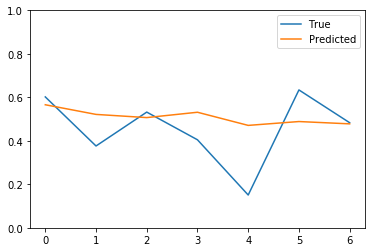

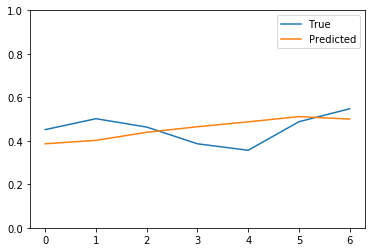

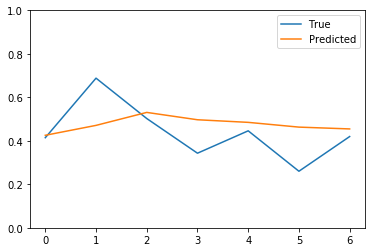

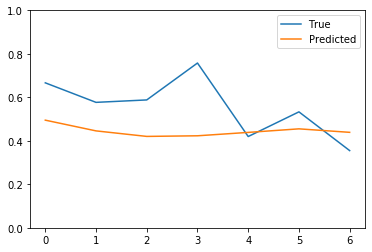

In [24]:
forecast_num = 10

for mode_num in range(20):
    plt.figure()
    plt.plot(train_outputs[forecast_num,:,mode_num],label='True')
    plt.plot(pred_outputs[forecast_num,:,mode_num],label='Predicted')
    plt.legend()
    plt.ylim((0,1.0))
    plt.show()